Connect to google drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


add json file for kaggle api

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [3]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:29<00:00, 47.9MB/s]
100% 2.29G/2.29G [00:29<00:00, 82.7MB/s]


In [ ]:
!unzip chest-xray-pneumonia.zip  && rm chest-xray-pneumonia.zip


import necessary modules

In [4]:
import re
import os
import random as rn
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

confirmation on switch to gpu
edit -> notbook setting -> gpu

In [5]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


observe data distribution, which displayed low images in validation set

In [6]:
path = '/content/gdrive/My Drive/Kaggle/chest_xray/'

#create file path for 6 seperate folders (normal vs pneumonia, train vs test vs val)
train_dir = os.path.join(path + 'train/')
test_dir = os.path.join(path + 'test/')
val_dir = os.path.join(path + 'val/')

#match for all images by selecting all files within the file paths
train_cases = tf.io.gfile.glob('chest_xray/train/*/*')
test_cases = tf.io.gfile.glob('chest_xray/test/*/*')
val_cases = tf.io.gfile.glob('chest_xray/val/*/*')

print('Number of images in training set = ',str(len(train_cases)))
print('Number of images in validation set = ',str(len(val_cases)))
print('Number of images in testing set = ',str(len(test_cases)))

Number of images in training set =  5216
Number of images in validation set =  16
Number of images in testing set =  624


combine training and validation set and split in 80:20 split

In [7]:
train_val_cases = train_cases
train_val_cases.extend(val_cases)
print(f'Total number of images : training_images + validation_images = {len(train_val_cases)}\n')
train_cases, val_cases = train_test_split(train_val_cases, test_size = 0.2)

print(f'After division of 80:20')
print(f'Total number of training images = {len(train_cases)}')
print(f'Total number of validation images = {len(val_cases)}')

Total number of images : training_images + validation_images = 5232

After division of 80:20
Total number of training images = 4185
Total number of validation images = 1047


rearrange newly assigned images to new destination file
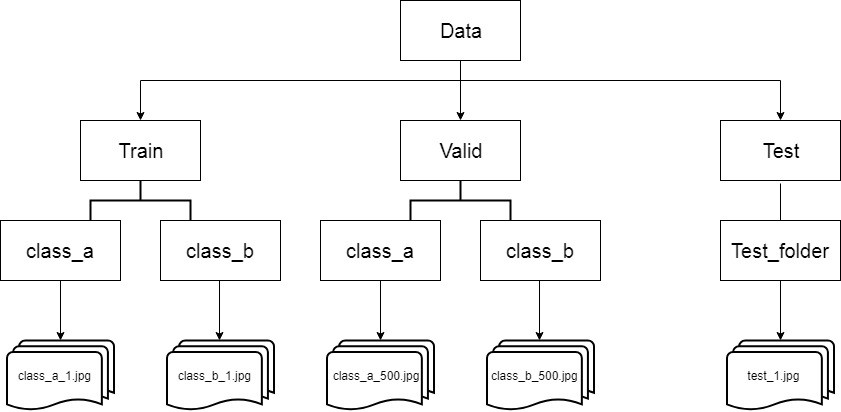![image.png](
)

make new directories and store on colab google

In [8]:
tf.io.gfile.makedirs('/kaggle/working/val_dataset/NORMAL/')
tf.io.gfile.makedirs('/kaggle/working/val_dataset/PNEUMONIA/')
tf.io.gfile.makedirs('/kaggle/working/train_dataset/NORMAL/')
tf.io.gfile.makedirs('/kaggle/working/train_dataset/PNEUMONIA/')

Seperate file based on file paths

In [10]:
for image in train_cases:
  parts_of_path = image.split('/')
  if 'PNEUMONIA' == parts_of_path[-2]:
      tf.io.gfile.copy(src = image, dst = '/kaggle/working/train_dataset/PNEUMONIA/' +  parts_of_path[-1])
  else:
      tf.io.gfile.copy(src = image, dst = '/kaggle/working/train_dataset/NORMAL/' +  parts_of_path[-1])
  

In [11]:
for ele in val_cases:
    parts_of_path = ele.split('/')

    if 'PNEUMONIA' == parts_of_path[-2]:
        tf.io.gfile.copy(src = ele, dst = '/kaggle/working/val_dataset/PNEUMONIA/' +  parts_of_path[-1])
    else:
        tf.io.gfile.copy(src = ele, dst = '/kaggle/working/val_dataset/NORMAL/' +  parts_of_path[-1])

In [12]:
print('Pneumonia x-ray images in training set after split = ',len(os.listdir('/kaggle/working/train_dataset/PNEUMONIA/')))
print('Normal x-ray images in training set after split = ',len(os.listdir('/kaggle/working/train_dataset/NORMAL/')))
print('Pneumonia x-ray images in validation set after split = ',len(os.listdir('/kaggle/working/val_dataset/PNEUMONIA/')))
print('Normal x-ray images in validation set after split = ',len(os.listdir('/kaggle/working/val_dataset/NORMAL/')))
print('Pneumonia x-ray images in test set = ',len(os.listdir('/content/gdrive/My Drive/Kaggle/chest_xray/test/PNEUMONIA/')))
print('Normal x-ray images in test set = ',len(os.listdir('/content/gdrive/My Drive/Kaggle/chest_xray/test/NORMAL/')))

Pneumonia x-ray images in training set after split =  3077
Normal x-ray images in training set after split =  1108
Pneumonia x-ray images in validation set after split =  806
Normal x-ray images in validation set after split =  241
Pneumonia x-ray images in test set =  390
Normal x-ray images in test set =  234


Visualise normal and pneumonia images by sampling from training set

In [13]:
train_dir='/kaggle/working/train_dataset/'
val_dir='/kaggle/working/val_dataset/'
test_dir='/content/gdrive/My Drive/Kaggle/chest_xray/test/'

train_normal_dir='/kaggle/working/train_dataset/NORMAL'
train_pneumonia_dir='/kaggle/working/train_dataset/PNEUMONIA'
val_normal_dir='/kaggle/working/val_dataset/NORMAL'
val_pneumonia_dir='/kaggle/working/val_dataset/PNEUMONIA'

In [14]:
train_normal_fnames=os.listdir(train_normal_dir)
train_pneumonia_fnames=os.listdir(train_pneumonia_dir)
normal_pix=[os.path.join(train_normal_dir,fname) for fname in train_normal_fnames[0:4]]
pneumonia_pix=[os.path.join(train_pneumonia_dir,fname) for fname in train_pneumonia_fnames[0:4]]

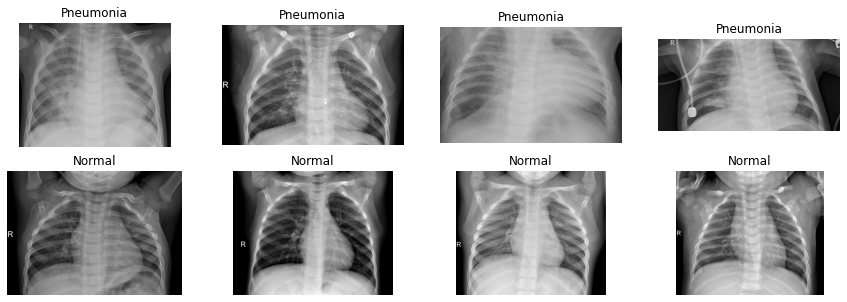

In [15]:
plt.figure(figsize=(15,5))
for i, path in enumerate(pneumonia_pix):
  plt.subplot(2,4,i+1)
  plt.axis('off')
  img = plt.imread(path)
  plt.imshow(img, cmap='gray')
  plt.title('Pneumonia')

for i, path in enumerate(normal_pix):
  plt.subplot(2,4,4 + i + 1)
  plt.axis('off')
  img = plt.imread(path)
  plt.imshow(img, cmap='gray')
  plt.title('Normal')

define model training parameters

In [16]:
batch_size = 128
img_height = 180
img_width = 180

model structure simple CNN

In [17]:
    model=tf.keras.models.Sequential([
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu',padding='same', input_shape=(img_height, img_width, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [18]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy','Precision','Recall'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 64)        3

image augmentation to fit in model.
the training datagen modifies each training image slightly in each epoch, which provides unseen data for the model for training.
all three datagens are rescaled and standardizes pixel values to [0,1]

In [20]:
train_datagen=ImageDataGenerator(rescale=1.0/255,
                                 rotation_range=30,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 zoom_range=0.2,
                                 )

val_datagen=ImageDataGenerator(rescale=1.0/255)

test_datagen=ImageDataGenerator(rescale=1.0/255)

train_generator=train_datagen.flow_from_directory(train_dir,color_mode="grayscale",target_size=(img_height,img_width),batch_size=128,class_mode='binary')

val_generator=val_datagen.flow_from_directory(val_dir,color_mode="grayscale",target_size=(img_height,img_width),batch_size=128,class_mode='binary')

test_generator=test_datagen.flow_from_directory(test_dir,color_mode="grayscale",target_size=(img_height,img_width),batch_size=128,class_mode='binary')

Found 4185 images belonging to 2 classes.
Found 1047 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Correct for dataset imbalance between the number of pneumonia and normal images

In [21]:
train_pneu_count = len(train_pneumonia_fnames)
train_norm_count = len(train_normal_fnames)
train_count = train_pneu_count + train_norm_count
initial_bias = np.log([train_pneu_count/ train_norm_count])
initial_bias
weight_for_0 = (1 / train_norm_count)*(train_count)/2.0 
weight_for_1 = (1 / train_pneu_count)*(train_count)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.89
Weight for class 1: 0.68


Train model, model reach 80% accuracy in detecting pneumonia from chest x ray images

In [22]:
history=model.fit(train_generator,validation_data=val_generator,epochs=30,verbose=2, class_weight = class_weight)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/30
33/33 - 85s - loss: 83.6183 - accuracy: 0.5661 - precision: 0.7491 - recall: 0.6162 - val_loss: 0.6854 - val_accuracy: 0.7622 - val_precision: 0.7712 - val_recall: 0.9826
Epoch 2/30
33/33 - 56s - loss: 1.0004 - accuracy: 0.4941 - precision: 0.7545 - recall: 0.4625 - val_loss: 0.6762 - val_accuracy: 0.7689 - val_precision: 0.7701 - val_recall: 0.9975
Epoch 3/30
33/33 - 56s - loss: 0.6892 - accuracy: 0.6411 - precision: 0.7692 - recall: 0.7312 - val_loss: 0.6195 - val_accuracy: 0.7593 - val_precision: 0.7674 - val_recall: 0.9864
Epoch 4/30
33/33 - 57s - loss: 2.1535 - accuracy: 0.6989 - precision: 0.8713 - recall: 0.6929 - val_loss: 0.8207 - val_accuracy: 0.6972 - val_precision: 0.7738 - val_recall: 0.8573
Epoch 5/30
33/33 - 55s - loss: 0.5620 - accuracy: 0.7350 - precision: 0.8990 - recall: 0.7205 - val_loss: 0.6680 - val_accuracy: 0.6304 -

Evaluation of model

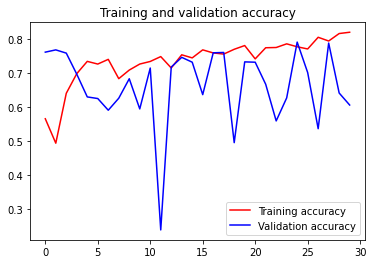

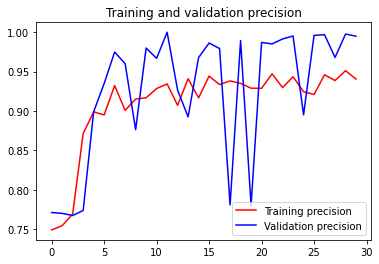

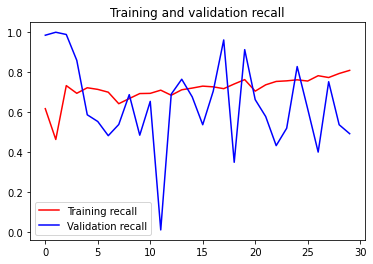

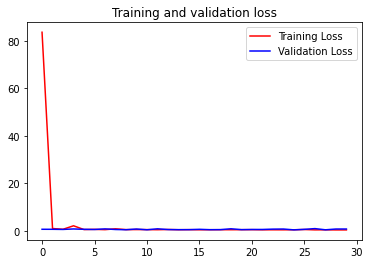

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_precision=history.history['precision']
val_precision=history.history['val_precision']

train_recall=history.history['recall']
val_recall=history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, train_precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()
plt.figure()

plt.plot(epochs, train_recall, 'r', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Fine tuning of model using kera callbacks

modelcheckpoint to only save the best performing model
earlystopping to stop when monitoring metrics such as loss stops improving

In [24]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("pneumonia_detection_model",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

include exponential learning rate that declines as epoch increases

In [31]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

train model with fine tuning parameters, which fine tunes on the basis of the original model

In [32]:
history=model.fit(train_generator,validation_data=val_generator,epochs=30,
                  verbose=2, class_weight = class_weight,
                  callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler])

Epoch 1/30
33/33 - 58s - loss: 0.4241 - accuracy: 0.8091 - precision: 0.9432 - recall: 0.7878 - val_loss: 0.5360 - val_accuracy: 0.7202 - val_precision: 0.9540 - val_recall: 0.6687
INFO:tensorflow:Assets written to: pneumonia_detection_model/assets
Epoch 2/30
33/33 - 56s - loss: 0.3793 - accuracy: 0.8354 - precision: 0.9536 - recall: 0.8157 - val_loss: 0.4129 - val_accuracy: 0.8090 - val_precision: 0.9935 - val_recall: 0.7568
INFO:tensorflow:Assets written to: pneumonia_detection_model/assets
Epoch 3/30
33/33 - 56s - loss: 0.3298 - accuracy: 0.8602 - precision: 0.9629 - recall: 0.8424 - val_loss: 1.5142 - val_accuracy: 0.4451 - val_precision: 0.9956 - val_recall: 0.2804
Epoch 4/30
33/33 - 56s - loss: 0.3447 - accuracy: 0.8480 - precision: 0.9556 - recall: 0.8320 - val_loss: 1.3257 - val_accuracy: 0.3992 - val_precision: 1.0000 - val_recall: 0.2196
Epoch 5/30
33/33 - 56s - loss: 0.3141 - accuracy: 0.8578 - precision: 0.9655 - recall: 0.8365 - val_loss: 0.6838 - val_accuracy: 0.7335 - va

Evaluate model using test datagen

In [33]:
test = model.evaluate_generator(test_generator, 624)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [35]:
print('loss  :', test[0])
print('accuracy  :', test[1])
print('Precision :', test[2])
print('Recall :', test[3])

loss  : 1.7207382917404175
accuracy  : 0.875
Precision : 0.888059675693512
Recall : 0.9153845906257629
